In [77]:
# Handle the imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt



In [78]:
# Get the encounters
encounters_df = pd.read_csv('csv/interactions.csv')

# Get the participants
participant_features = pd.read_csv('csv/user_features.csv')

# Remove some useless columns. These are censored in the dataset, so they are useless.
participant_features = participant_features.drop(columns=['ethnicity',	'religion',	'politics'])

male_df   = participant_features[participant_features['gender'] == 'male']
female_df = participant_features[participant_features['gender'] == 'female']

male_df = male_df.drop(columns=['gender', 'attracted_to'])
female_df = female_df.drop(columns=['gender', 'attracted_to'])


# Add prefix to column names
male_df.columns = ['male_' + col for col in male_df.columns]
female_df.columns = ['female_' + col for col in female_df.columns]

# Merge the two dataframes
df = encounters_df.merge(male_df, on='male_user_id', how='left')
df = df.merge(female_df, on='female_user_id', how='left')

# Drop the useless columns
df = df.drop(columns=['event_id', 'female_user_id', 'male_user_id', 'does_male_like_female', 'does_female_like_male'])


Next we will create some extra features (beyond the ones directly in the data). 
These will be:
- height ratio
- attractiveness ratio
- income bucket difference
- age difference
- intelligence ratio

In [79]:
# Create the new features
df['height_ratio'] = df['male_height_inches'] / df['female_height_inches']
df['attractiveness_ratio'] = df['male_avg_physical_attractiveness_rating'] / df['female_avg_physical_attractiveness_rating']
df['income_bucket_ratio'] = df['male_income_bucket'] / df['female_income_bucket']
df['age_ratio'] = df['male_age'] / df['female_age']
df['intelligence_ratio'] = df['male_iq_share_correct'] / df['female_iq_share_correct']



Before training and assessing the model, let's first look at the data.

In [80]:
print(df.shape)
print(df.columns)

positive_df = df[df['mutual_interest'] == 1]

print(positive_df.shape)

(1895, 56)
Index(['mutual_interest', 'male_age', 'male_iq_share_correct',
       'male_agreeableness', 'male_conscientiousness', 'male_extraversion',
       'male_neuroticism', 'male_openness',
       'male_avg_physical_attractiveness_rating', 'male_height_inches',
       'male_income_bucket', 'male_nicotine_score', 'male_alcohol_score',
       'male_marijuana_score', 'male_has_used_psychedelics',
       'male_behavioral_health_score', 'male_sex_partners_score',
       'male_get_along_well_with_family_score',
       'male_political_tolerance_score', 'male_ethnicity_importance_score',
       'male_religion_importance_score', 'male_politics_importance_score',
       'male_num_children_wanted_score', 'male_already_has_kids',
       'male_casual_sex_score', 'male_hard_work_and_success_belief_score',
       'female_age', 'female_iq_share_correct', 'female_agreeableness',
       'female_conscientiousness', 'female_extraversion', 'female_neuroticism',
       'female_openness', 'female_avg_phy

Let's now prepere the data for training and testing, then run logistic regression on it, then assess performance.

In [81]:

# Drop the rows with missing values
df = df.dropna()

# Split the data into features (X) and label (y)
X = df.drop(columns=['mutual_interest'])
y = df['mutual_interest']

# First split: Get 70% for training and 30% for test_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_test.shape)

(560, 55)
(561, 55)


In [82]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Note: we use only transform on the test set

# Convert scaled data back to DataFrames to retain feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Accuracy: 0.63
Precision: 0.17
Recall: 0.50
F1 Score: 0.25
Confusion Matrix:
[[319 172]
 [ 35  35]]
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       491
           1       0.17      0.50      0.25        70

    accuracy                           0.63       561
   macro avg       0.54      0.57      0.50       561
weighted avg       0.81      0.63      0.69       561

ROC AUC Score: 0.57


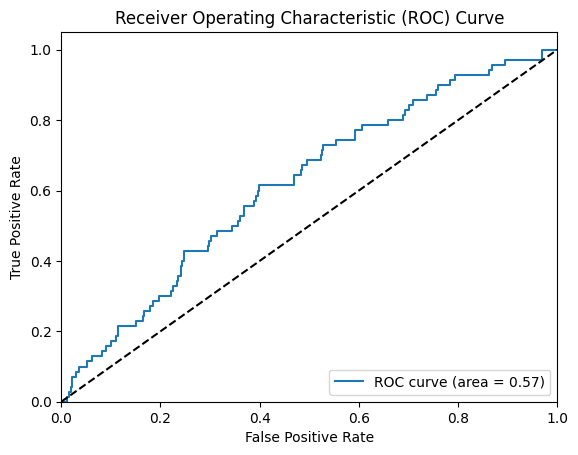

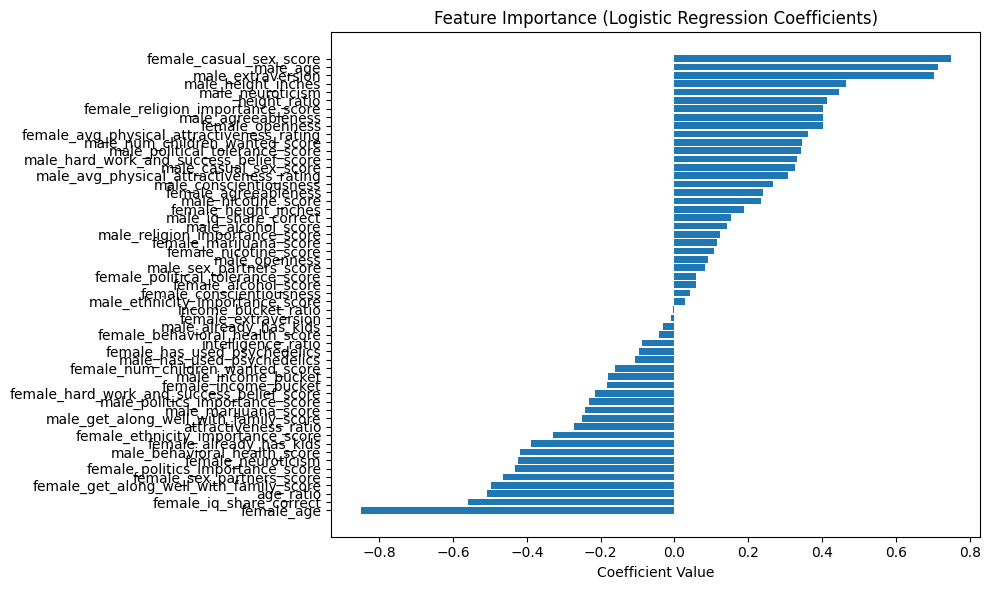

In [83]:
# Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter=10000, class_weight='balanced')
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Optionally, you can also display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.2f}")

# If you also want to plot the ROC curve:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])  # get the probabilities of class 1
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Get feature names if they exist (if not, use numbers)
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Get coefficients
coefficients = logreg.coef_[0]  # This extracts the coefficients for each feature

# Plot
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(coefficients)
plt.barh(range(X_train.shape[1]), coefficients[sorted_idx])
plt.yticks(range(X_train.shape[1]), feature_names[sorted_idx])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


# 4. Hyperparameter tuning using RandomizedSearchCV
model = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100, 200],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'max_depth': [-1, 5, 10, 15, 20],
    'feature_fraction': [0.6, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3},{0:1, 1:1}]
}

# Using StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_grid, 
                                   n_iter=100, 
                                   cv=skf, 
                                   scoring='f1',  
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs=-1)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_





Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 47, number of negative: 326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Accuracy: 0.82
Precision: 0.31
Recall: 0.40
F1 Score: 0.35
Confusion Matrix:
[[430  61]
 [ 42  28]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       491
           1       0.31      0.40      0.35        70

    accuracy                           0.82       561
   macro avg       0.61      0.64      0.62       561
weighted avg       0.84      0.82      0.83       561



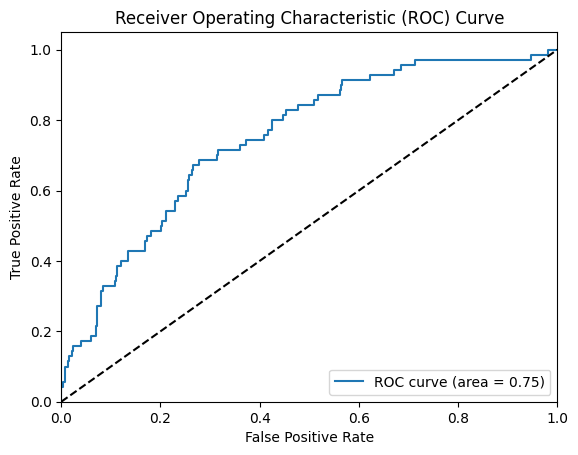

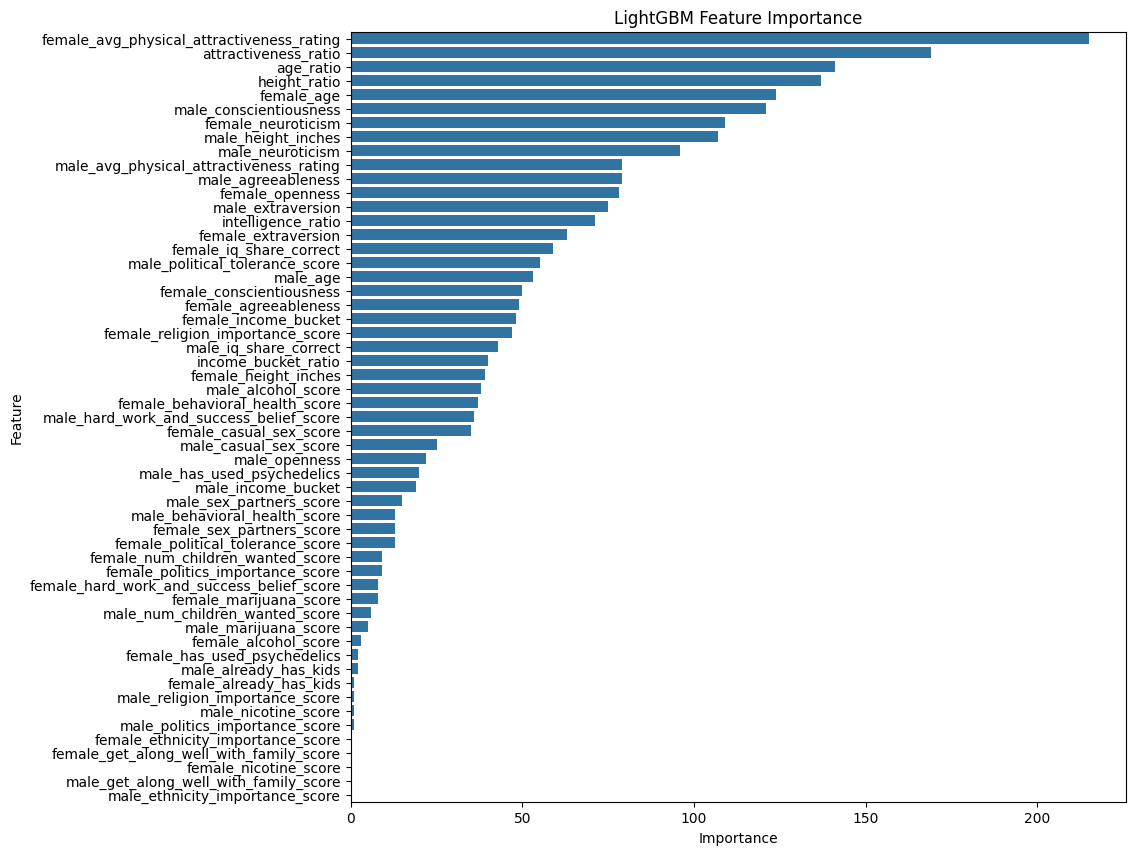

In [85]:
import seaborn as sns


# Make predictions on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Getting probabilities for the positive class
y_pred = np.round(y_pred_proba)  # Convert probabilities to class labels

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print(classification_report(y_test, y_pred))

# ROC AUC score and plot
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Note: Use probabilities here
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# Feature importance plot
feature_imp = pd.DataFrame({'Feature': X_test.columns, 'Importance': best_model.feature_importances_})
feature_imp = feature_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=feature_imp)
plt.title('LightGBM Feature Importance')
plt.show()